# Top 10 most frequent 6-grams

This notebook demonstrates how to use the <ins>SIA API</ins> to find the top 10 most frequent 6-grams from a set of Sharkspeare plays.

_@Hugh, some explaination about the purpose of doing this experiment_

Firstly, a number of dependency modules are imported here.

- `requests`: is used for sending requests to the SIA API.
- `matplotlib.pyplot`: we use the Matplotlib to create the chart based on the results from the SIA API.
- `IPython.display`: is used for rendering the results from the SIA API as HTML tables.

In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Next, we set up the API endpoint here. In this example, we use the <ins>Word Frequencies API</ins>.

In [2]:
request_url = "https://sia.ardc-hdcl-sia-iaw.cloud.edu.au/api/v1/word-frequencies"

In order to use the API, an API key is requried to authenticate the requests. The API key must be specified in a custom HTTP header `X-API-KEY` and sent along with every request.

You should use your own API keys for your own notebooks and always keep your keys confidential. Read more about <ins>how to create API keys</ins> in SIA. 

In [3]:
api_key = "255446bcdde7ca9fe776258d09e8411bbb8d1cade2ebd6aba440f80f6817c3fd"

Then, we start to prepare the request data which we can send to the Word Frequencies API. In this example, we are going to use a text set containing 20 Shakespear plays which has been already uploaded in the SIA platform. Instead of passing the actual text contents to the API, we can tell the API to use one of the texts or text sets from SIA by specifying its ID.

The URL of a text/text set page from <ins>SIA Application</ins> indicates the ID of that text/text set. For example:

```
https://sia.ardc-hdcl-sia-iaw.cloud.edu.au/text-sets/86
```

In this case, the ID of the "20 Shakespear plays" text set is `86`.

We will also pass serveral word frequecies options to the Word Frequencies API. These options are:

- `blockMethod`: We set the block method to `0`(By text), which makes each text from the text set as a single segment.
- `numberOfNGrams`: We want to find the frequencies of `6` adjacent words.
- `outputSize`: We set it to `10` as we are only interested in the top 10 most frequent words.
- `excludeWords`: We are excluding some common punctuation marks from our analysis.

To view more details about options of Word Frequencies API, read the <ins>API documentation</ins>.

_@Hugh: more explainations about these options may be specified here_

In [4]:
request_data = {
    'textSet': 86,
    'option':{
        'blockMethod': 0,       # Segment by text
        'numberOfNGrams' : 6,
        'outputSize': 10,
        'excludeWords': ["[","\\", "]", "_", "`", "!", "\"", "#", "%", "'", "(", ")", "+", ",", "-", "–", ".", "/", ":", ";", "{", "|", "}", "=", "~", "?" ],
    }
}

The SIA API accept JSON as the request data. Here we have constructed a Python dictionary object with the text set identifier and the word frequencies options. Next we are going to put all things together and use the [Requests](https://requests.readthedocs.io/en/latest/) module to send the request to the SIA API.

In [5]:
# Make the API Request
response = requests.post(request_url, json=request_data, headers={"X-API-KEY": api_key}, timeout=1200)

We have specified the API endpoint, request data we defined earlier and the `X-API-KEY` HTTP header for the API request and received the response. Please note that the API call can take serveral minutes to finish based on the size of the text or text set. Therefore, we have set the request timeout to `1200` seconds.

Before we start unpacking the response data, we want to make sure the API call was successful by checking the HTTP response code. Read the <ins>API documentation</ins> for all error codes.

In [6]:
print(f"{response.status_code} {response.reason}")
assert response.status_code == 200
response_data = response.json()

200 OK


Now, we have the response data ready from Word Frequencies API. We firstly want to display the top most frequent 6-grams in a table that we can know what they are and the frequencies in each text from the text sets. We are going to firstly unpack the response data and make it into a tabular data format. Note that the words returned from the Word Frequencies API are sorted from the highest to lowest frequency by default, and the orders of words returned from blocks are consistent. Read more about the <ins>response data</ins> of Word Frequencies API. 

In [7]:
table_headers = []
table_rows = []
for block in response_data['blocks']:
    # Add table header row.
    if len(table_headers) == 0:
        table_headers.append(['Word'])
    table_headers[0].append(block['name'])

    # Add data rows.
    for i in range(len(block['frequencies'])):
        frequency = block['frequencies'][i]
        # Check whether the row has been created. If not, initialise the row with the word text.
        if i > len(table_rows) - 1:
            table_rows.append([frequency['word']])
        # Append the word frequency to its corresponding row.
        table_rows[i].append(frequency['value'])

    # Add the "Word Types" row.
    i += 1
    if i > len(table_rows) - 1:
        table_rows.append(['Word Types'])
    table_rows[i].append(block['uniqueWordCount'])

    # Add the "Size" row.
    i += 1
    if i > len(table_rows) - 1:
        table_rows.append(['Size'])
    table_rows[i].append(block['size'])

We have created two 2-dimension list. The `table_headers` list contains a single table header row of the block names. The `table_rows` list contains rows of frequencies of the 6-grams. The next step is to generate the HTML markups based on the tabular data and render it.

In [8]:
# Start with the opening tags of container and table elements.
html = '<div style="overflow-x: auto; margin-top: 40px;"><table border="1">'

# Append table headers.
for table_row in table_headers:
    html += '<tr>'
    for table_cell in table_row:
        html += f'<th style="white-space: nowrap;">{table_cell}</td>'
    html += '</tr>'

# Append HTML for table rows.
for table_row in table_rows:
    html += '<tr>'
    for table_cell in table_row:
        html += f'<td>{table_cell}</td>'
    html += '</tr>'

# Close the table and container elements.
html += '</table></div>'

# Render the HTML.
display(HTML(html))

hey.ho.the.wind.and.the,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0
ho.the.wind.and.the.rain,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0
for.the.rain.it.raineth.every,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0
i.could.find.in.my.heart,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0
the.rain.it.raineth.every.day,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0
with.hey.ho.the.wind.and,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,0
chooseth.me.shall.get.as.much,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
get.as.much.as.he.deserves,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
give.me.a.cup.of.sack,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
how.now.what.is.the.matter,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Word Types,20652,18922,11606,22193,24180,22265,15732,19937,16224,13638,17985,13925,16424,19539,18105,21799,20236,13374,15245,21399


Now we have our table rendered. From the table, we can see that two 6-grams each appear 5 times in a single play; one 6-gram appears in 4 different plays. The 6-grams can be overlapping ("hey ho the wind and the", "ho the wind and the rain").

_@Hugh: more insights about the table can be described here_

Next, we are going to create a bar chart to show the overall top 10 most frequent 6-grams with their frequencies in the text set. Because word frequencies returned from the API are in the context of each block, we will need to sum up the word frequencies from all blocks first.

In [9]:
# Create a dictionary to hold word frequencies
word_frequency_map = {}
for block in response_data["blocks"]:
    for freq in block['frequencies']:
        word = freq['word']
        value = freq['value']
        word_frequency_map[word] = word_frequency_map.get(word, 0) + value

We have created a dictionary with the words as keys, and total word frequencies in the text set as values. Then we will use the [Matplotlib](https://matplotlib.org/) library to visualise this. We set the 6-grams as the x-axis, and their word frequencies as the y-axis.

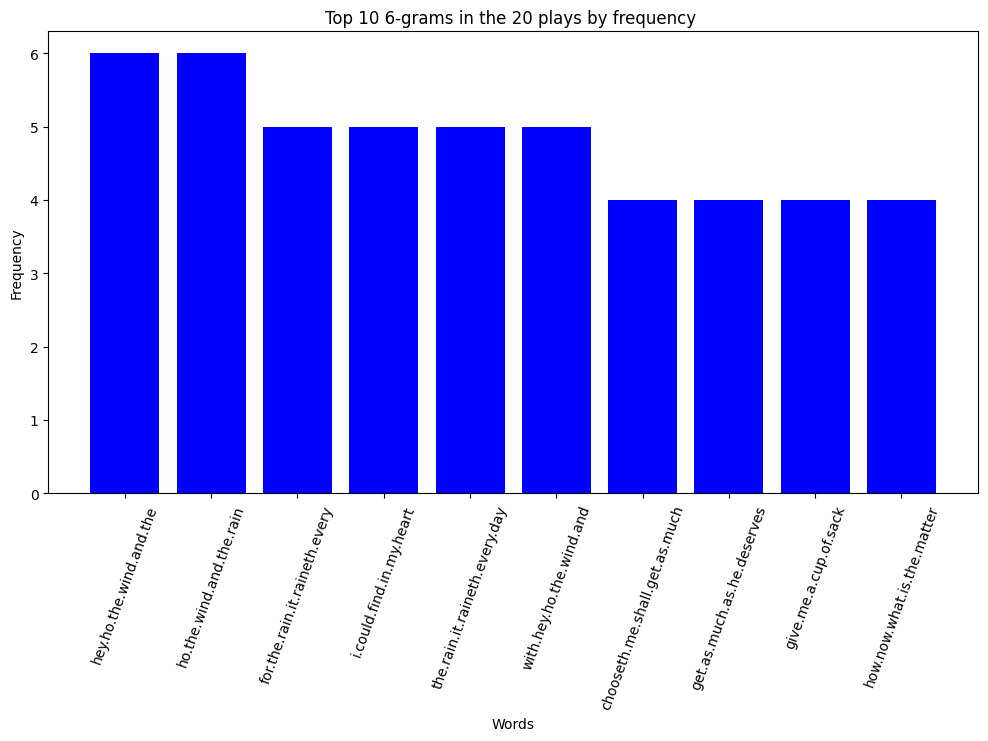

In [10]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(list(word_frequency_map.keys()), list(word_frequency_map.values()), color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 6-grams in the 20 plays by frequency ')
plt.xticks(rotation=70)
plt.show()

_@Hugh: some insights about the chart_